Gold rows: 93206


date,location_id,country,latitude,longitude,pm10_avg,pm25_avg,pm10_count,pm25_count,sensors,measurements
2026-01-16,81609,DE,48.872,9.084,15.66,13.18,1,1,1,2
2026-01-16,732,NL,51.698,4.886,4.4,2.9,1,1,1,2
2026-01-16,873,DE,47.696,8.068,4.3,1.29,1,1,1,2
2026-01-16,9196,DE,49.194,12.526,20.08,14.52,1,1,1,2
2026-01-16,11311,PL,52.192,20.9,71.21,41.83,1,1,1,2
2026-01-16,26079,IT,45.958,12.492,44.65,33.07,1,1,1,2
2026-01-16,32625,PL,51.08,16.97,27.85,15.88,1,1,1,2
2026-01-16,33280,PL,52.152,21.052,22.84,8.7,1,1,1,2
2026-01-16,39154,NL,53.3572785,6.8746592,7.28,3.3,1,1,1,2
2026-01-16,41485,BE,51.05399281354,3.70132237673,4.08,2.0,1,1,1,2


Latest date: 2026-01-30
Suspicious PM2.5 / PM10 ratios: 12


location_id,pm10_avg,pm25_avg,pm_ratio
62942,42.22,80.33,1.9026527711984842
72572,0.21,0.27,1.2857142857142858
65922,5.53,14.57,2.634719710669078
40368,87.83,184.0,2.094956165319367
31483,1.0,60.0,60.0
32089,13.0,16.0,1.2307692307692308
68264,0.01,1.43,143.0
56860,26.0,52.48,2.0184615384615383
57358,16.9,41.5,2.4556213017751483
11424,42.7,64.9,1.5199063231850118


Detected 112 PM10 anomalies
Detected 124 PM2.5 anomalies


location_id,pm10_avg,pm25_avg,pm_ratio,pm10_zscore,pm25_zscore
83705,1999.9,999.9,0.49997499874993745,10.023473409145298,9.485254240118522
85481,1999.9,999.9,0.49997499874993745,10.023473409145298,9.485254240118522
88297,1999.9,999.9,0.49997499874993745,10.023473409145298,9.485254240118522
85038,417.61,386.84,0.9263188142046406,1.890303100204779,3.5185237571074084
59266,1999.9,999.9,0.49997499874993745,10.023473409145298,9.485254240118522
63132,693.9,653.61,0.9419368785127541,3.310468572183478,6.114916754453304
78849,1999.9,999.9,0.49997499874993745,10.023473409145298,9.485254240118522
81403,755.72,707.12,0.9356904673688667,3.6282311748029112,6.635713655484076
66984,2658.97,2658.97,1.0,13.411176393752056,25.632488674675084
58456,1999.9,999.9,0.49997499874993745,10.023473409145298,9.485254240118522



Logging quality metrics / anomalies:
Quality metrics / anomalies:{'date': '2026-01-30', 'locations_checked': 10124, 'pm10_anomalies': 112, 'pm25_anomalies': 124, 'ratio_violations': 12}



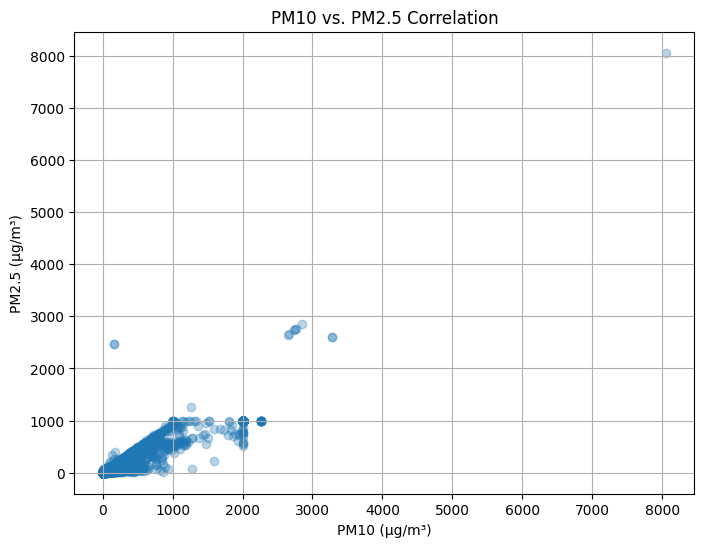

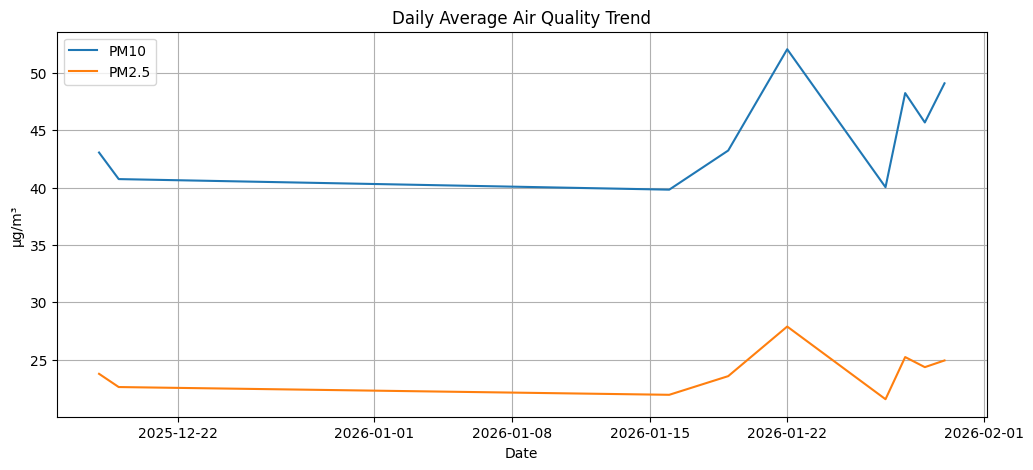

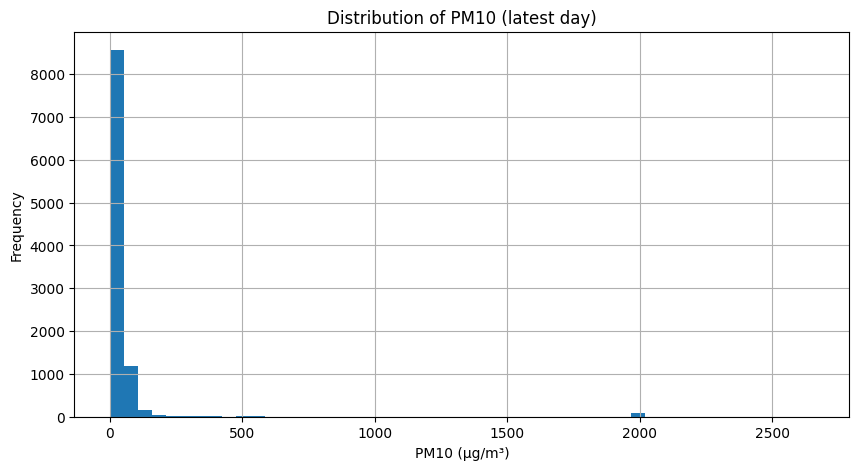

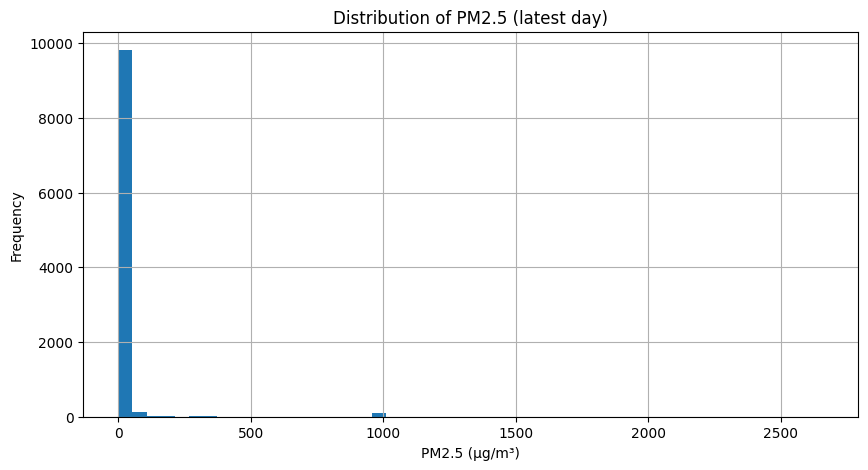

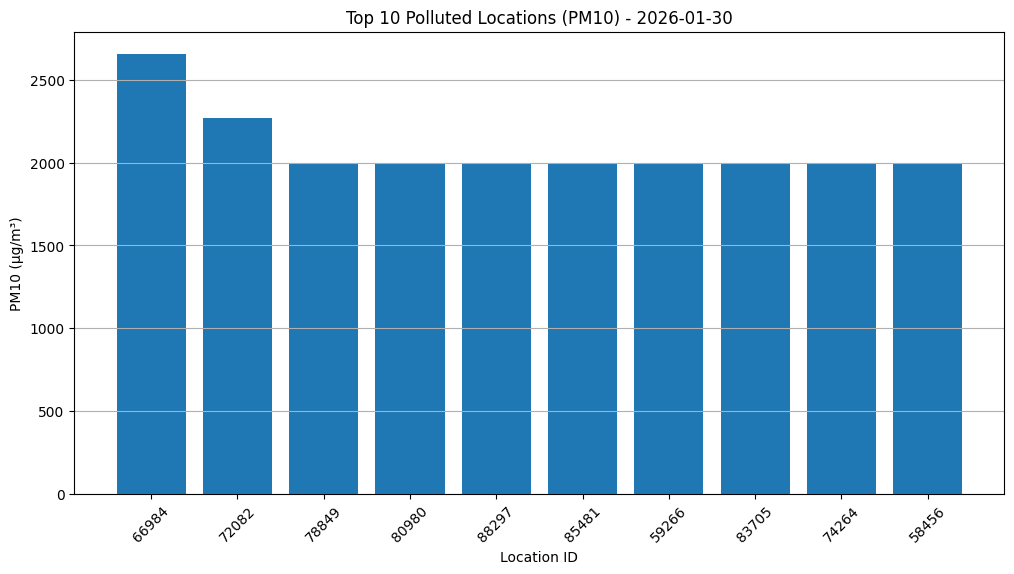

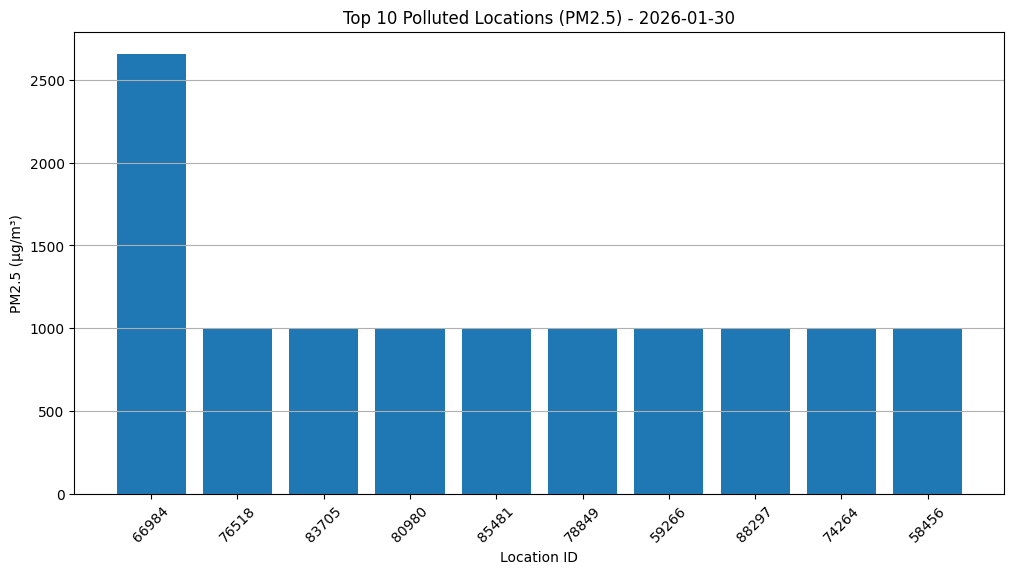

In [0]:
"""
05_visualization.ipynb

Purpose:
- Visualize Gold air quality data
- Demonstrate analytical value of the pipeline
- Read-only consumption of Gold tables

NOTE:
This notebook is for data quality validation and exploratory analysis.
It does NOT represent real-time air quality. It provides exploratory, ad-hoc, and quality-focused analysis
to validate Gold layer correctness (data quality, statistical sanity, and behavioral validation).
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import (
    col,
    avg
)

# Read Gold table for python sanity checks
gold_df_python = spark.read.table("air_quality_gold.daily_air_quality")

print(f"Gold rows: {gold_df_python.count()}")
display(gold_df_python.limit(10))

# Get latest day
latest_date = (
    gold_df_python
    .selectExpr("max(date) as max_date")
    .collect()[0]["max_date"]
)
print("Latest date:", latest_date)

# Focus on latest date
latest_df = (
    gold_df_python
    .filter(col("date") == latest_date)
)

pdf = latest_df.select(
    "location_id",
    "pm10_avg",
    "pm25_avg"
).dropna().toPandas()

# Calculation - Ratio between PM2.5 and PM10 sanity check (physical plausibility)
# Physically PM2.5 ⊆ PM10
# PM2.5 ≫ PM10 is suspicious
# Guard against division by zero
pdf = pdf[pdf["pm10_avg"] > 0]

# Calculate PM2.5 / PM10 ratio
pdf["pm_ratio"] = pdf["pm25_avg"] / pdf["pm10_avg"]
suspicious_ratio = pdf[pdf["pm_ratio"] > 1.2]

print(f"Suspicious PM2.5 / PM10 ratios: {len(suspicious_ratio)}")
display(suspicious_ratio)

# Visualization - Detect unusually high PM10 and PM2.5 values (z-score outlier detection / broken parsing)
# Define z-score threshold
Z_THRESHOLD = 3

# Calculate Z-score for PM10
pm10_mean = pdf["pm10_avg"].mean()
pm10_std = pdf["pm10_avg"].std()

pdf["pm10_zscore"] = (pdf["pm10_avg"] - pm10_mean) / pm10_std

# Flag anomalies (e.g. > 3 standard deviations)
anomalies_pm10 = pdf[pdf["pm10_zscore"].abs() > Z_THRESHOLD]

print(f"Detected {len(anomalies_pm10)} PM10 anomalies")

# Calculate Z-score for PM2.5
pm25_mean = pdf["pm25_avg"].mean()
pm25_std = pdf["pm25_avg"].std()

pdf["pm25_zscore"] = (pdf["pm25_avg"] - pm25_mean) / pm25_std

# Flag anomalies (e.g. > 3 standard deviations)
anomalies_pm25 = pdf[pdf["pm25_zscore"].abs() > Z_THRESHOLD]

print(f"Detected {len(anomalies_pm25)} PM2.5 anomalies")
display(anomalies_pm25.head(10))

if pm10_std == 0 or np.isnan(pm10_std):
    print("Warning: PM10 standard deviation undefined")

# Logging quality metrics / anomalies
# NOTE: Anomalies here do not imply bad air quality, only potential data issues
print("\nLogging quality metrics / anomalies:")

quality_metrics = {    
                   "date": str(latest_date),
    "locations_checked": len(pdf),
    "pm10_anomalies": len(anomalies_pm10),
    "pm25_anomalies": len(anomalies_pm25),
    "ratio_violations": len(suspicious_ratio)
}

print(f"Quality metrics / anomalies:{quality_metrics}\n")

# Visualization - Correlation between PM10 and PM2.5 (structural correlation)
scatter_pdf = (
    gold_df_python
    .select("pm10_avg", "pm25_avg")
    .dropna()
    .toPandas()
)

# Plot scatter plot
plt.figure(figsize=(8, 6))

plt.scatter(
    scatter_pdf["pm10_avg"],
    scatter_pdf["pm25_avg"],
    alpha=0.3
)

plt.title("PM10 vs. PM2.5 Correlation")
plt.xlabel("PM10 (µg/m³)")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid(True)
plt.show()

# Visualization - Time stability check (stability across runs)
time_pdf = (
    gold_df_python
    .groupBy("date")
    .agg(
        avg("pm10_avg").alias("avg_pm10"),
        avg("pm25_avg").alias("avg_pm25")
    )
    .orderBy("date")
    .toPandas()
)

plt.figure(figsize=(12, 5))
plt.plot(time_pdf["date"], time_pdf["avg_pm10"], label="PM10")
plt.plot(time_pdf["date"], time_pdf["avg_pm25"], label="PM2.5")
plt.legend()
plt.title("Daily Average Air Quality Trend")
plt.xlabel("Date")
plt.ylabel("µg/m³")
plt.grid(True)
plt.show()

# Visualization - Distribution histogram plots (catching bad ingestion / distribution sanity)
# Distribution of PM10
plt.figure(figsize=(10, 5))
plt.hist(pdf["pm10_avg"], bins=50)
plt.title("Distribution of PM10 (latest day)")
plt.xlabel("PM10 (µg/m³)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Distribution of PM2.5
plt.figure(figsize=(10, 5))
plt.hist(pdf["pm25_avg"], bins=50)
plt.title("Distribution of PM2.5 (latest day)")
plt.xlabel("PM2.5 (µg/m³)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Visualization - Top 10 most polluted locations (ranking logic correctness)
# Top locations by PM10
top_locations_df_pm10 = (
    gold_df_python
    .filter(gold_df_python.date == latest_date)
    .orderBy(gold_df_python.pm10_avg.desc())
    .limit(10)
)

top_locations_pdf_pm10 = top_locations_df_pm10.toPandas()

# Plot bar chart
plt.figure(figsize=(12, 6))

plt.bar(
    top_locations_pdf_pm10["location_id"].astype(str),
    top_locations_pdf_pm10["pm10_avg"]
)

plt.title(f"Top 10 Polluted Locations (PM10) - {latest_date}")
plt.xlabel("Location ID")
plt.ylabel("PM10 (µg/m³)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# Top locations by PM2.5
top_locations_df_pm25 = (
    gold_df_python
    .filter(gold_df_python.date == latest_date)
    .orderBy(gold_df_python.pm25_avg.desc())
    .limit(10)
)

top_locations_pdf_pm25 = top_locations_df_pm25.toPandas()

# Plot bar chart
plt.figure(figsize=(12, 6))

plt.bar(
    top_locations_pdf_pm25["location_id"].astype(str),
    top_locations_pdf_pm25["pm25_avg"]
)

plt.title(f"Top 10 Polluted Locations (PM2.5) - {latest_date}")
plt.xlabel("Location ID")
plt.ylabel("PM2.5 (µg/m³)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# dbutils.notebook.exit(
#     f"Gold Quality Checks: visualization sanity checks completed"
# )